In [152]:
import matplotlib

matplotlib.rcParams["figure.figsize"] = (10, 3)


In [153]:
import pandas as pd


In [154]:
MAN_HEIGHT_M = 1.7
EARTH_GRAVITY = 9.81
ACCELERATION_ERROR = 0.5 * EARTH_GRAVITY
VELOCITY_ERROR = 0.5
BOUNDING_BOX_SCALE_FACTOR = 0.7

INTERPOLATION_SPAN_P = 50
INTERPOLATION_SPAN_V = 50
INTERPOLATION_SPAN_A = 100

# Load data


In [155]:
df = pd.read_pickle("boxes_2.df")
len(df)


295

In [156]:
import pickle
import numpy as np

with open("boxes_2.pk", "rb") as pk_file:
    pk = pickle.load(pk_file)
_all_timestamps = pk["timestamp"]
_all_boxes = pk["box"]
all_timestamps = np.array(_all_timestamps)
all_boxes = np.array(_all_boxes)

print(f"{len(all_timestamps)= }, {len(all_boxes)= } ")


len(all_timestamps)= 295, len(all_boxes)= 295 


In [157]:
_all_timestamps[:5]

[1691475236.0333667,
 1691475236.0667334,
 1691475236.1001,
 1691475236.1334667,
 1691475236.1668334]

# Transform data


In [158]:
def scale_box(box, f):
    (x, y, w, h) = box
    return x + int(.5 * w * (1 - f)), y + int(.5 * h * (1 - f)), w * f, h * f


def bigger_box(box):
    f = 1 / BOUNDING_BOX_SCALE_FACTOR
    return scale_box(box, f)

In [159]:
# df.box = df.box.apply(lambda box: bigger_box(box))

In [160]:
m_to_p_ratio = MAN_HEIGHT_M / df.box.head(1).item()[3]
m_to_p_ratio

0.003074141048824593

In [161]:
df.index = pd.to_datetime(df.index, unit="s")
df["y"] = df.box.apply(lambda r: -r[1] * m_to_p_ratio)


<Axes: title={'center': 'Vertical position in meters'}>

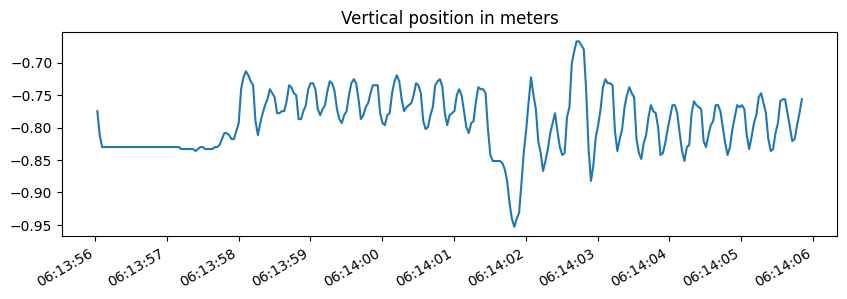

In [162]:
df.y.plot(title='Vertical position in meters')

In [163]:
# all_y = np.apply_along_axis(lambda r: -r[1] * m_to_p_ratio, axis=1, arr=all_boxes)
all_y = all_boxes[:, 1] * -m_to_p_ratio
all_y[:5]

array([-0.77468354, -0.81157324, -0.83001808, -0.83001808, -0.83001808])

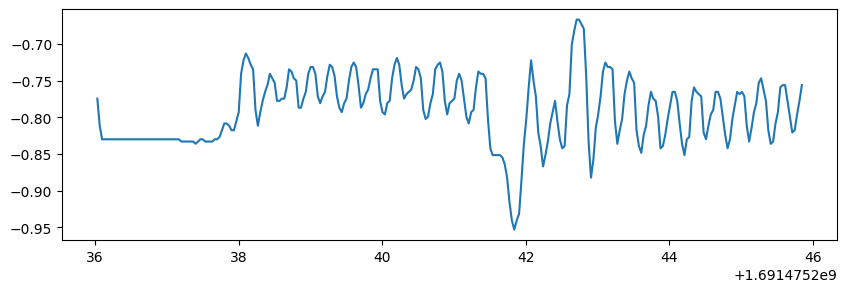

In [164]:
from matplotlib import pyplot as pp

pp.plot(all_timestamps, all_y)


# $\tilde{y}$,$\dot{y}$,$\ddot{y}$


In [165]:
df


,box,y
2023-08-08 06:13:56.033366680,"[587, 252, 553, 553]",-0.774684
2023-08-08 06:13:56.066733360,"[636, 264, 578, 578]",-0.811573
2023-08-08 06:13:56.100100040,"[643, 270, 591, 591]",-0.830018
2023-08-08 06:13:56.133466721,"[644, 270, 596, 596]",-0.830018
2023-08-08 06:13:56.166833401,"[645, 270, 596, 596]",-0.830018
...,...,...
2023-08-08 06:14:05.709700108,"[602, 267, 692, 692]",-0.820796
2023-08-08 06:14:05.743066549,"[608, 266, 684, 684]",-0.817722
2023-08-08 06:14:05.776433229,"[604, 259, 690, 690]",-0.796203
2023-08-08 06:14:05.809799910,"[604, 253, 690, 690]",-0.777758


2023-08-08 06:13:56.033         NaN
2023-08-08 06:13:56.034   -0.774684
2023-08-08 06:13:56.035   -0.775801
2023-08-08 06:13:56.036   -0.776919
2023-08-08 06:13:56.037   -0.778037
2023-08-08 06:13:56.038   -0.779155
2023-08-08 06:13:56.039   -0.780273
2023-08-08 06:13:56.040   -0.781391
2023-08-08 06:13:56.041   -0.782509
2023-08-08 06:13:56.042   -0.783627
Freq: L, Name: y, dtype: float64

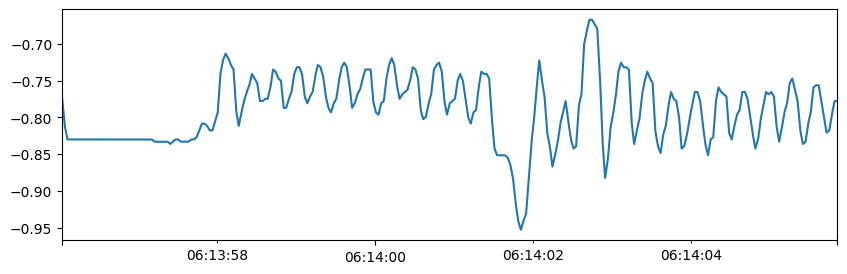

In [166]:
interpolated = df.y.resample('L').ffill(limit=1)
# print(interpolated.head(4))
# interpolated.plot()
interpolated = interpolated.interpolate()
interpolated.plot()
interpolated.head(10)

len(interp_timestamp)= 9810, len(interp_y)= 9810


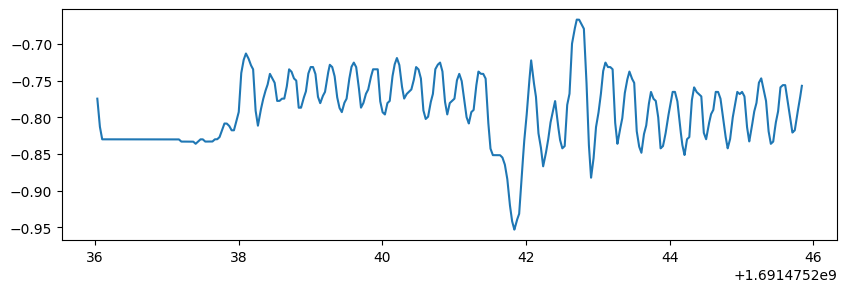

In [167]:
import numpy as np

hist_y = np.array(df.y, dtype=np.float32)
interp_timestamp = np.arange(all_timestamps[0], all_timestamps[-1], 0.001)
interp_y = np.interp(interp_timestamp, all_timestamps, all_y)
print(f"{len(interp_timestamp)= }, {len(interp_y)= }")
pp.plot(interp_timestamp, interp_y)


2023-08-08 06:13:56.033         NaN
2023-08-08 06:13:56.034   -0.774684
2023-08-08 06:13:56.035   -0.775254
2023-08-08 06:13:56.036   -0.775831
2023-08-08 06:13:56.037   -0.776416
2023-08-08 06:13:56.038   -0.777009
2023-08-08 06:13:56.039   -0.777609
2023-08-08 06:13:56.040   -0.778216
2023-08-08 06:13:56.041   -0.778830
2023-08-08 06:13:56.042   -0.779453
Freq: L, Name: y, dtype: float64

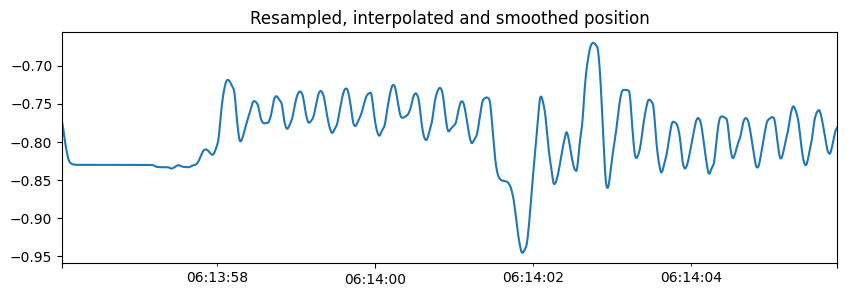

In [168]:
smoothed = interpolated.ewm(span= INTERPOLATION_SPAN_P).mean()
smoothed.plot(title="Resampled, interpolated and smoothed position")
smoothed.head(10)

In [169]:
# tested with python3 & numpy 1.15.2
# usage:

# data_n = 100000000
# data = ((0.5*np.random.randn(data_n)+0.5) % 1) * 100

# span = 5000  # span >= 1
# alpha = 2/(span+1)  # for pandas` span parameter

# # com = 1000  # com >= 0
# # alpha = 1/(1+com)  # for pandas` center-of-mass parameter

# # halflife = 100  # halflife > 0
# # alpha = 1 - np.exp(np.log(0.5)/halflife)  # for pandas` half-life parameter

# result = ewma_vectorized_safe(data, alpha)

import numpy as np


def ewma_vectorized_safe(data, alpha, row_size=None, dtype=None, order="C", out=None):
    """
    Reshapes data before calculating EWMA, then iterates once over the rows
    to calculate the offset without precision issues
    :param data: Input data, will be flattened.
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param row_size: int, optional
        The row size to use in the computation. High row sizes need higher precision,
        low values will impact performance. The optimal value depends on the
        platform and the alpha being used. Higher alpha values require lower
        row size. Default depends on dtype.
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the desired output. If not provided or `None`,
        a freshly-allocated array is returned.
    :return: The flattened result.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float32
    else:
        dtype = np.dtype(dtype)

    row_size = int(row_size) if row_size is not None else get_max_row_size(alpha, dtype)

    if data.size <= row_size:
        # The normal function can handle this input, use that
        return ewma_vectorized(data, alpha, dtype=dtype, order=order, out=out)

    if data.ndim > 1:
        # flatten input
        data = np.reshape(data, -1, order=order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    row_n = int(data.size // row_size)  # the number of rows to use
    trailing_n = int(data.size % row_size)  # the amount of data leftover
    first_offset = data[0]

    if trailing_n > 0:
        # set temporary results to slice view of out parameter
        out_main_view = np.reshape(out[:-trailing_n], (row_n, row_size))
        data_main_view = np.reshape(data[:-trailing_n], (row_n, row_size))
    else:
        out_main_view = out
        data_main_view = data

    # get all the scaled cumulative sums with 0 offset
    ewma_vectorized_2d(data_main_view, alpha, axis=1, offset=0, dtype=dtype, order="C", out=out_main_view)

    scaling_factors = (1 - alpha) ** np.arange(1, row_size + 1)
    last_scaling_factor = scaling_factors[-1]

    # create offset array
    offsets = np.empty(out_main_view.shape[0], dtype=dtype)
    offsets[0] = first_offset
    # iteratively calculate offset for each row
    for i in range(1, out_main_view.shape[0]):
        offsets[i] = offsets[i - 1] * last_scaling_factor + out_main_view[i - 1, -1]

    # add the offsets to the result
    out_main_view += offsets[:, np.newaxis] * scaling_factors[np.newaxis, :]

    if trailing_n > 0:
        # process trailing data in the 2nd slice of the out parameter
        ewma_vectorized(
            data[-trailing_n:], alpha, offset=out_main_view[-1, -1], dtype=dtype, order="C", out=out[-trailing_n:]
        )
    return out


def get_max_row_size(alpha, dtype=float):
    assert 0.0 <= alpha < 1.0
    # This will return the maximum row size possible on
    # your platform for the given dtype. I can find no impact on accuracy
    # at this value on my machine.
    # Might not be the optimal value for speed, which is hard to predict
    # due to numpy's optimizations
    # Use np.finfo(dtype).eps if you  are worried about accuracy
    # and want to be extra safe.
    epsilon = np.finfo(dtype).tiny
    # If this produces an OverflowError, make epsilon larger
    return int(np.log(epsilon) / np.log(1 - alpha)) + 1


# The 1D ewma function
def ewma_vectorized(data, alpha, offset=None, dtype=None, order="C", out=None):
    """
    Calculates the exponential moving average over a vector.
    Will fail for large inputs.
    :param data: Input data
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param offset: optional
        The offset for the moving average, scalar. Defaults to data[0].
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the input. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if data.ndim > 1:
        # flatten input
        data = data.reshape(-1, order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if offset is None:
        offset = data[0]

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # scaling_factors -> 0 as len(data) gets large
    # this leads to divide-by-zeros below
    scaling_factors = np.power(1.0 - alpha, np.arange(data.size + 1, dtype=dtype), dtype=dtype)
    # create cumulative sum array
    np.multiply(data, (alpha * scaling_factors[-2]) / scaling_factors[:-1], dtype=dtype, out=out)
    np.cumsum(out, dtype=dtype, out=out)

    # cumsums / scaling
    out /= scaling_factors[-2::-1]

    if offset != 0:
        offset = np.array(offset, copy=False).astype(dtype, copy=False)
        # add offsets
        out += offset * scaling_factors[1:]

    return out


# The 2D ewma function
def ewma_vectorized_2d(data, alpha, axis=None, offset=None, dtype=None, order="C", out=None):
    """
    Calculates the exponential moving average over a given axis.
    :param data: Input data, must be 1D or 2D array.
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param axis: The axis to apply the moving average on.
        If axis==None, the data is flattened.
    :param offset: optional
        The offset for the moving average. Must be scalar or a
        vector with one element for each row of data. If set to None,
        defaults to the first value of each row.
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Ignored if axis is not None.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the desired output. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    assert data.ndim <= 2

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if axis is None or data.ndim < 2:
        # use 1D version
        if isinstance(offset, np.ndarray):
            offset = offset[0]
        return ewma_vectorized(data, alpha, offset, dtype=dtype, order=order, out=out)

    assert -data.ndim <= axis < data.ndim

    # create reshaped data views
    out_view = out
    if axis < 0:
        axis = data.ndim - int(axis)

    if axis == 0:
        # transpose data views so columns are treated as rows
        data = data.T
        out_view = out_view.T

    if offset is None:
        # use the first element of each row as the offset
        offset = np.copy(data[:, 0])
    elif np.size(offset) == 1:
        offset = np.reshape(offset, (1,))

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # calculate the moving average
    row_size = data.shape[1]
    row_n = data.shape[0]
    scaling_factors = np.power(1.0 - alpha, np.arange(row_size + 1, dtype=dtype), dtype=dtype)
    # create a scaled cumulative sum array
    np.multiply(
        data,
        np.multiply(alpha * scaling_factors[-2], np.ones((row_n, 1), dtype=dtype), dtype=dtype)
        / scaling_factors[np.newaxis, :-1],
        dtype=dtype,
        out=out_view,
    )
    np.cumsum(out_view, axis=1, dtype=dtype, out=out_view)
    out_view /= scaling_factors[np.newaxis, -2::-1]

    if not (np.size(offset) == 1 and offset == 0):
        offset = offset.astype(dtype, copy=False)
        # add the offsets to the scaled cumulative sums
        out_view += offset[:, np.newaxis] * scaling_factors[np.newaxis, 1:]

    return out


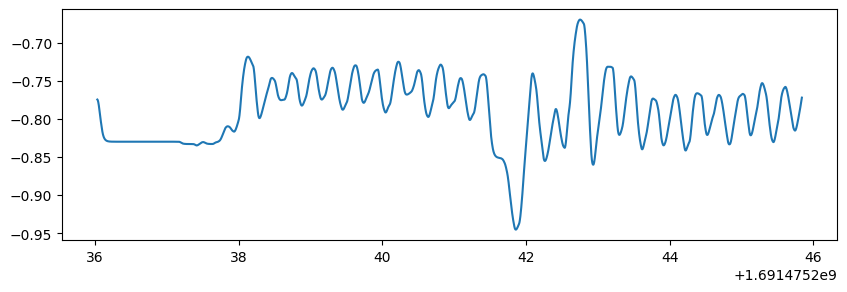

In [170]:
# from window_ops.ewm import ewm_mean
# from window_ops.rolling import rolling_mean


def ewma(vector, span=None, alpha=0.5):
    if span is not None:
        alpha = 2 / (span + 1)
    alpha_beta = np.array([alpha, 1 - alpha])
    out = np.zeros_like(vector)
    out.fill(None)
    for i, v in enumerate(vector):
        out[i] = vector[i] if i == 0 else np.dot(alpha_beta, np.array([v, out[i - 1]]))
    return out


# smoothed_y = ewm_mean(interp_y, alpha=0.5)
# smoothed_y = rolling_mean(interp_y, window_size=int(0.5 * INTERPOLATION_SPAN_P))
# smoothed_y = ewma_vectorized_safe(interp_y, alpha=0.5)
smoothed_y = ewma(interp_y, span= INTERPOLATION_SPAN_P)
pp.plot(interp_timestamp, smoothed_y)


2023-08-08 06:13:56.033         NaN
2023-08-08 06:13:56.034         NaN
2023-08-08 06:13:56.035   -0.570113
2023-08-08 06:13:56.036   -0.573912
2023-08-08 06:13:56.037   -0.577758
2023-08-08 06:13:56.038   -0.581652
2023-08-08 06:13:56.039   -0.585591
2023-08-08 06:13:56.040   -0.589575
2023-08-08 06:13:56.041   -0.593604
2023-08-08 06:13:56.042   -0.597676
Freq: L, Name: y, dtype: float64

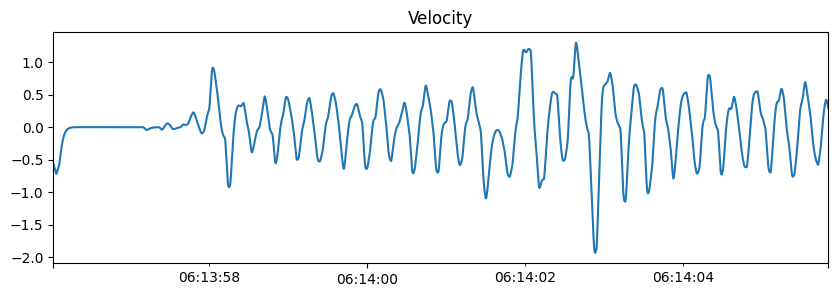

In [171]:
velocity = (smoothed.diff() * 1000).ewm(span=INTERPOLATION_SPAN_V).mean()
velocity.plot(title="Velocity")
velocity.head(10)

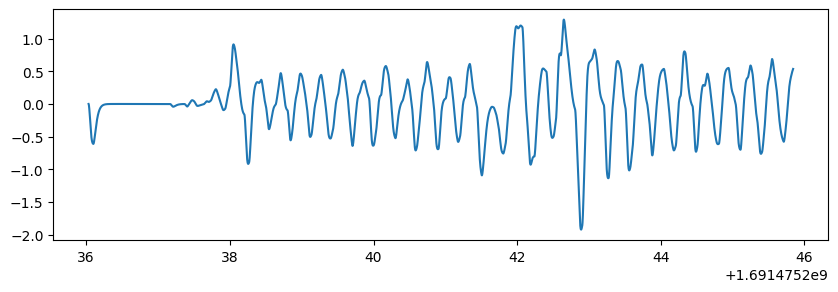

In [172]:
all_velocity = np.diff(smoothed_y, prepend=interp_y[0])* 1000
all_velocity = ewma(all_velocity, span= INTERPOLATION_SPAN_V)

pp.plot(interp_timestamp, all_velocity)


<Axes: title={'center': 'Acceleration'}>

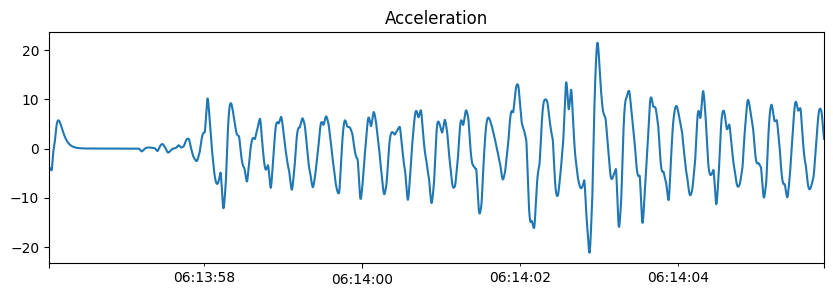

In [173]:
acceleration = (velocity.diff() * 1000).ewm(span=INTERPOLATION_SPAN_A).mean()
# acceleration = (velocity.diff() * 1000).rolling(window=5*INTERPOLATION_SPAN_A).min()
# (velocity.diff() * 1000).plot()
acceleration.plot(title="Acceleration")


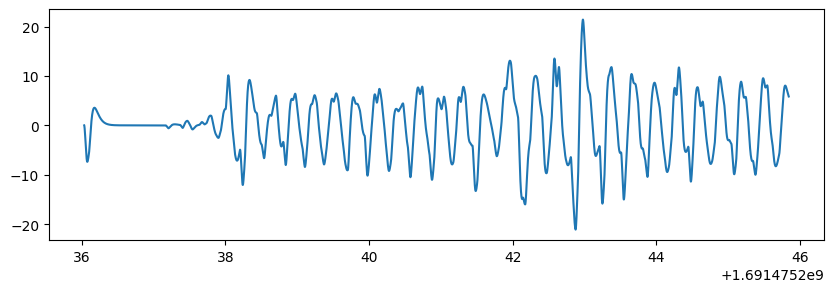

In [174]:
all_acceleration = np.diff(all_velocity, prepend=0)* 1000
all_acceleration = ewma(all_acceleration, span= INTERPOLATION_SPAN_A)

pp.plot(interp_timestamp, all_acceleration)


In [175]:
df = pd.DataFrame(
    {
        "y": smoothed,
        "v": velocity,
        'a': acceleration.shift(-int(INTERPOLATION_SPAN_A/2))
        # "a": acceleration,
    }
)
df.to_csv("data.csv")


# Detect


In [176]:
df["freefall"] = (df.a + EARTH_GRAVITY).abs() < ACCELERATION_ERROR
# df['still'] = (df.v.abs() < VELOCITY_ERROR)
df["local_maximum"] = (df.y.shift(1) < df.y) & (df.y.shift(-1) <= df.y)


<Axes: >

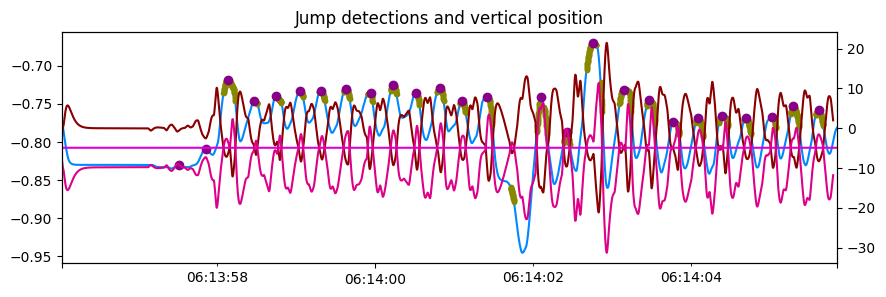

In [177]:
# ((df.freefall & df.local_maximum).astype(float) * 0.3).plot(marker='o')
smoothed.plot(title="Jump detections and vertical position", color="#0088FF")
df.a.plot(secondary_y=True, color="#880000")
(df[(df.freefall)].y).plot(marker=".", linestyle="None", color="#888800")
(df[(df.local_maximum)].y).plot(marker="o", linestyle="None", color="#880088")

ser = df["y"].copy(deep=True)  # use copy() → without modifying the original DF
ser.values.fill(-ACCELERATION_ERROR)
ser.plot(secondary_y=True, linestyle="-", color="#dd00dd")

ser2 = -(df.a + EARTH_GRAVITY).copy(deep=True)  # use copy() → without modifying the original DF
# ser2.values.fill(-ACCELERATION_ERROR)
ser2.plot(secondary_y=True, linestyle="-", color="#dd0088")

# (-df.local_maximum.astype(float)*0.1).plot()
# (df.freefall.astype(float)*0.1).plot()


<Axes: >

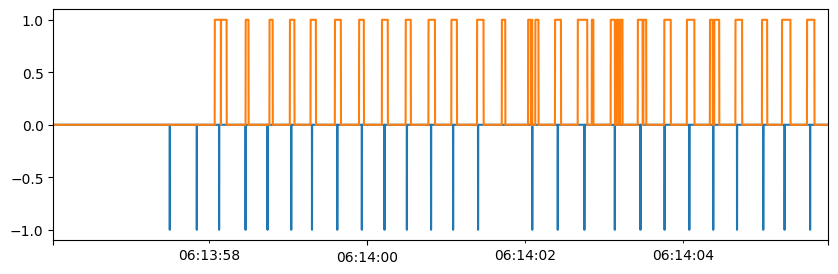

In [178]:
(-df.local_maximum.astype(float)).plot()
df.freefall.astype(float).plot()


In [179]:
import numba

@numba.njit
def shift5_numba(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result


all_freefall =np.abs(shift5_numba(all_acceleration,-int(INTERPOLATION_SPAN_A/2)) + EARTH_GRAVITY) < ACCELERATION_ERROR
# df['still'] = (df.v.abs() < VELOCITY_ERROR)
all_local_maximum = np.logical_and(shift5_numba(smoothed_y,1) < smoothed_y,shift5_numba(smoothed_y,-1) <= smoothed_y)
# all_local_maximum.shape

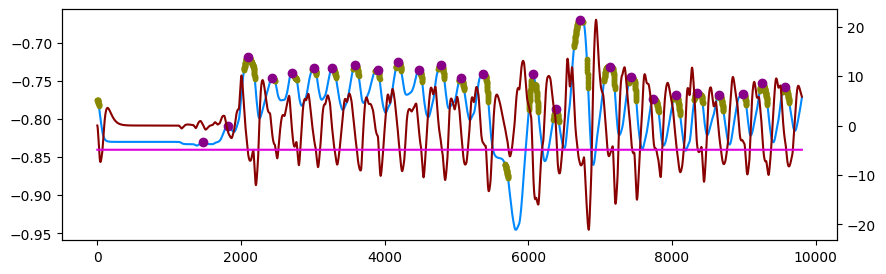

In [180]:
# ((df.freefall & df.local_maximum).astype(float) * 0.3).plot(marker='o')
pp.plot(smoothed_y, color="#0088FF")
ff = np.zeros_like(smoothed_y)
ff.fill(None)
ff[all_freefall] = smoothed_y[all_freefall]
pp.plot(ff, marker=".", linestyle="None", color="#888800")

ff = np.zeros_like(smoothed_y)
ff.fill(None)
ff[all_local_maximum] = smoothed_y[all_local_maximum]
pp.plot(ff, marker="o", linestyle="None", color="#880088")

ax = pp.gca()  # Get current axis
ax2 = ax.twinx()  # make twin axis based on x
ax2.plot(all_acceleration, color="#880000")

ser = np.zeros_like(smoothed_y)
ser.fill(-ACCELERATION_ERROR)
ax2.plot(ser, linestyle="-", color="#dd00dd")

ser2 = -(all_acceleration + EARTH_GRAVITY)
# ser2.values.fill(-ACCELERATION_ERROR)
# ax2.plot(ser2, linestyle="-", color="#dd0088")

# (-df.local_maximum.astype(float)*0.1).plot()
# (df.freefall.astype(float)*0.1).plot()


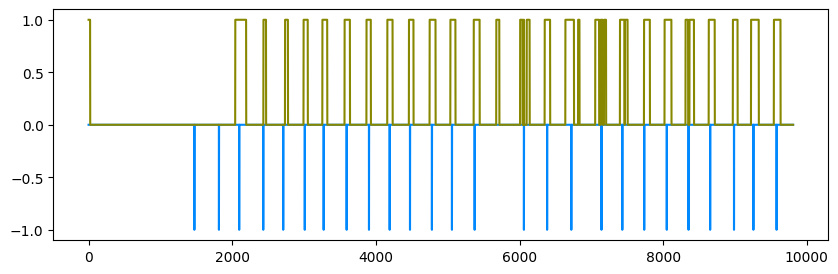

In [181]:
pp.plot(-1*all_local_maximum, color="#0088FF")
pp.plot(all_freefall, color="#888800")
# df.freefall.astype(float).plot()
